<a href="https://colab.research.google.com/github/PaulToronto/DataCamp_TimeSeries/blob/main/03_Window_Functions_Rolling_and_Expanding_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 - Window Functions - Rolling and Expanding Metrics

This chapter will show you how to use window function to calculate time series metrics for both rolling and expanding windows.

## Imports and `data_path`

In [1]:
import pandas as pd
import numpy as np

from numpy.random import normal, seed, choice
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = 'https://raw.githubusercontent.com/'
data_path += 'PaulToronto/DataCamp_TimeSeries/main/'

## Rolling window functions with pandas

- **Windows** identify sub periods for your time series
- Calculate metrics for sub periods inside the window
- Create a new times series of metrics
- Two types of windows:
  1. **Rolling**: maintains same size, sliding
  2. **Expanding**: contain all prior values

### Calculate a rolling average

In [3]:
data = pd.read_csv(data_path + 'stock_data/apple_google.csv', parse_dates=['Date'], index_col='Date')
data.drop('AAPL', axis=1, inplace=True)
data = data.loc[:'2016']
data.columns = ['price']
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1761 non-null   float64
dtypes: float64(1)
memory usage: 27.5 KB


In [4]:
data.head()

,price
Date,
2010-01-04,313.06
2010-01-05,311.68
2010-01-06,303.83
2010-01-07,296.75
2010-01-08,300.71


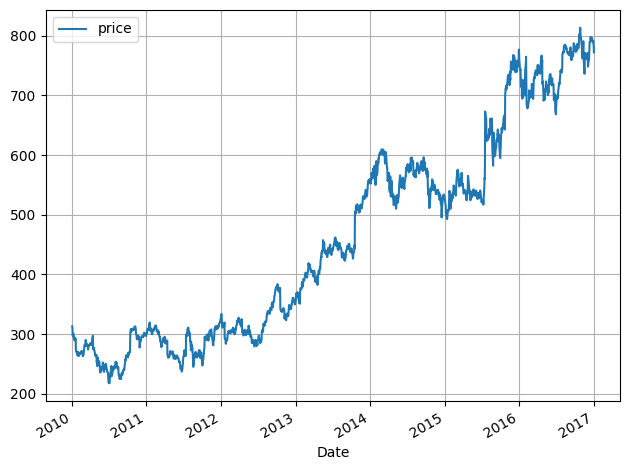

In [5]:
data.plot()
plt.grid()
plt.tight_layout()
plt.show()

#### Integer-based window size

- With an integer-based window size, pandas will only calculate the value (mean in our example), if the **window** has no missing values
  - You can change this default behaviour by setting the `min_periods` parameter to a value less that the window size

In [6]:
data.rolling(window=30).mean()

,price
Date,
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,NaN
2010-01-08,NaN
...,...
2016-12-23,773.216333
2016-12-27,774.467333
2016-12-28,776.099667


In [7]:
data.isnull().sum(), data.rolling(window=30).mean().isnull().sum()

(price    0
 dtype: int64,
 price    29
 dtype: int64)

In [8]:
data.tail(30).mean(), data.iloc[-30:].mean()

(price    777.154333
 dtype: float64,
 price    777.154333
 dtype: float64)

In [9]:
data.iloc[-31:-1].mean()

price    776.909667
dtype: float64

In [10]:
data.iloc[-32:-2].mean()

price    776.099667
dtype: float64

In [11]:
data.rolling(window=30).mean().iloc[29], data.iloc[0:30].mean()

(price    280.912333
 Name: 2010-02-16 00:00:00, dtype: float64,
 price    280.912333
 dtype: float64)

In [12]:
# With an integer-based window size, pandas will only
#. calculate the value (mean in our example),
#. if the **window** has no missing values
# You can change this default behaviour by setting
#. the `min_periods` parameter to a value less that the window size
data.rolling(window=30, min_periods=3).mean().head()

,price
Date,
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,309.523333
2010-01-07,306.330000
2010-01-08,305.206000


In [13]:
data.iloc[0:3].mean(), data.iloc[0:4].mean(), data.iloc[0:5].mean()

(price    309.523333
 dtype: float64,
 price    306.33
 dtype: float64,
 price    305.206
 dtype: float64)

#### Offset-based window size

- When the window is fixed in terms of period length, the number of observations will vary

In [14]:
data.head()

,price
Date,
2010-01-04,313.06
2010-01-05,311.68
2010-01-06,303.83
2010-01-07,296.75
2010-01-08,300.71


In [15]:
data.rolling(window='30D').mean()

,price
Date,
2010-01-04,313.060000
2010-01-05,312.370000
2010-01-06,309.523333
2010-01-07,306.330000
2010-01-08,305.206000
...,...
2016-12-23,778.723333
2016-12-27,780.145714
2016-12-28,780.946190


In [16]:
data.iloc[0:2].mean()

price    312.37
dtype: float64

### 90 day rolling mean

- here contrast integer based as well
- note, the larger the window, the smoother the curve

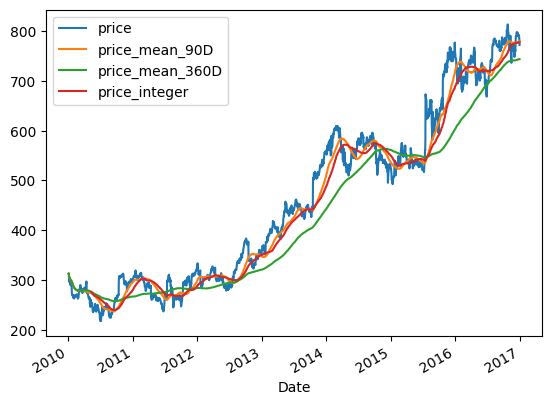

In [17]:
ri90 = data.rolling(window=90).mean()
r90 = data.rolling(window='90D').mean()
r360 = data.rolling(window='360D').mean()
data.join(r90.add_suffix('_mean_90D')).join(r360.add_suffix('_mean_360D')).join(ri90.add_suffix('_integer')).plot();

### Multiple rolling metrics (using the `.agg` method)

In [18]:
r = data['price'].rolling('90D').agg(['mean', 'std'])
r

,mean,std
Date,,
2010-01-04,313.060000,NaN
2010-01-05,312.370000,0.975807
2010-01-06,309.523333,4.978618
2010-01-07,306.330000,7.570597
2010-01-08,305.206000,7.021562
...,...,...
2016-12-23,778.787969,15.793301
2016-12-27,778.954839,16.108577
2016-12-28,779.116774,16.118732


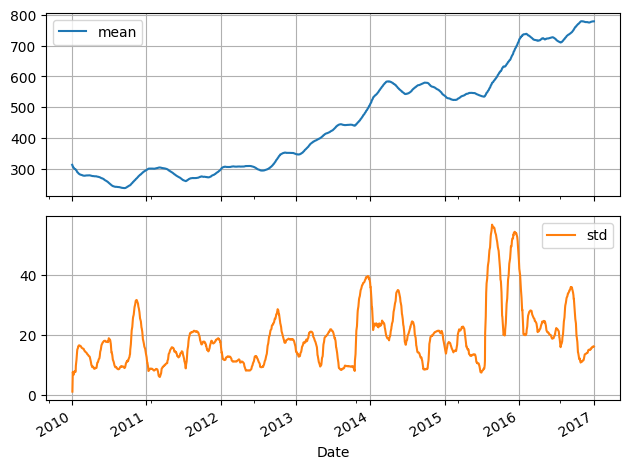

In [19]:
r.plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

By looking at the above graph, you can easily discern periods of heightened volatility.

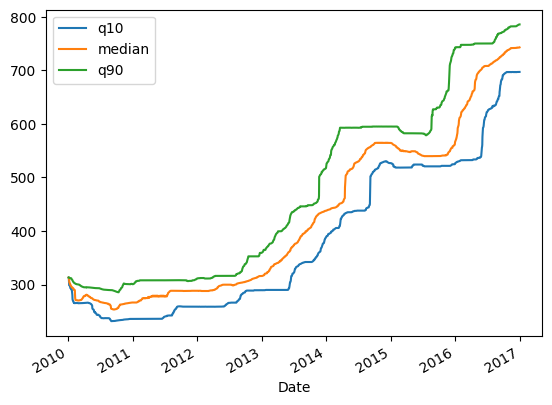

In [20]:
rolling = data['price'].rolling('360D')

q10 = rolling.quantile(0.1).to_frame('q10')
median = rolling.median().to_frame('median')
q90 = rolling.quantile(0.9).to_frame('q90')

pd.concat([q10, median, q90], axis=1).plot();

### Exercises

In [21]:
data = pd.read_csv(data_path + 'air_quality_data/ozone_nyc.csv', parse_dates=['date'], index_col='date')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6291 entries, 2000-01-01 to 2017-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6167 non-null   float64
dtypes: float64(1)
memory usage: 98.3 KB


In [22]:
data['90D'] = data['Ozone'].rolling('90D').mean()
data['360D'] = data['Ozone'].rolling('360D').mean()

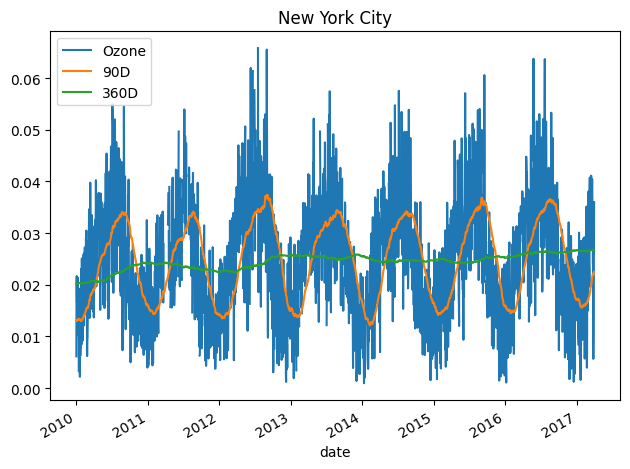

In [23]:
data.loc['2010':].plot(title='New York City')
plt.tight_layout()
plt.show()

In [24]:
data = pd.read_csv(data_path + 'air_quality_data/ozone_nyc.csv',
                   parse_dates=['date'],
                   index_col='date').dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6167 entries, 2000-01-01 to 2017-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6167 non-null   float64
dtypes: float64(1)
memory usage: 96.4 KB


In [29]:
rolling_stats = data['Ozone'].rolling(360).agg(['mean', 'std'])
rolling_stats

,mean,std
date,,
2000-01-01,NaN,NaN
2000-01-02,NaN,NaN
2000-01-03,NaN,NaN
2000-01-04,NaN,NaN
2000-01-05,NaN,NaN
...,...,...
2017-03-27,0.026629,0.011599
2017-03-28,0.026583,0.011617
2017-03-29,0.026584,0.011617


In [30]:
stats = data.join(rolling_stats)
stats

,Ozone,mean,std
date,,,
2000-01-01,0.004032,NaN,NaN
2000-01-02,0.009486,NaN,NaN
2000-01-03,0.005580,NaN,NaN
2000-01-04,0.008717,NaN,NaN
2000-01-05,0.013754,NaN,NaN
...,...,...,...
2017-03-27,0.005640,0.026629,0.011599
2017-03-28,0.013870,0.026583,0.011617
2017-03-29,0.034341,0.026584,0.011617


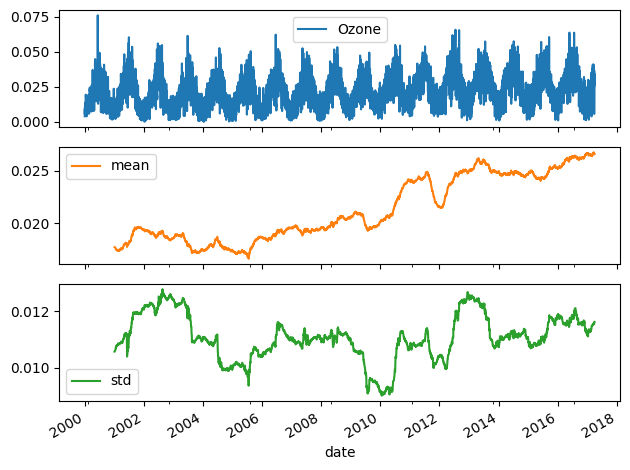

In [31]:
stats.plot(subplots=True)
plt.tight_layout()
plt.show()

In [33]:
data = pd.read_csv(data_path + 'air_quality_data/ozone_nyc.csv',
                   parse_dates=['date'],
                   index_col='date')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6291 entries, 2000-01-01 to 2017-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6167 non-null   float64
dtypes: float64(1)
memory usage: 98.3 KB


In [34]:
data.head()

,Ozone
date,
2000-01-01,0.004032
2000-01-02,0.009486
2000-01-03,0.005580
2000-01-04,0.008717
2000-01-05,0.013754


In [35]:
data = data.resample('D').interpolate()
data.head()

,Ozone
date,
2000-01-01,0.004032
2000-01-02,0.009486
2000-01-03,0.005580
2000-01-04,0.008717
2000-01-05,0.013754


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6300 entries, 2000-01-01 to 2017-03-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6300 non-null   float64
dtypes: float64(1)
memory usage: 98.4 KB


In [37]:
rolling = data['Ozone'].rolling(360)
rolling

Rolling [window=360,center=False,axis=0,method=single]

In [38]:
data['q10'] = rolling.quantile(0.1)
data['q50'] = rolling.median()
data['q90'] = rolling.quantile(0.9)

data

,Ozone,q10,q50,q90
date,,,,
2000-01-01,0.004032,NaN,NaN,NaN
2000-01-02,0.009486,NaN,NaN,NaN
2000-01-03,0.005580,NaN,NaN,NaN
2000-01-04,0.008717,NaN,NaN,NaN
2000-01-05,0.013754,NaN,NaN,NaN
...,...,...,...,...
2017-03-27,0.005640,0.01134,0.026424,0.040893
2017-03-28,0.013870,0.01134,0.026388,0.040893
2017-03-29,0.034341,0.01134,0.026388,0.040893


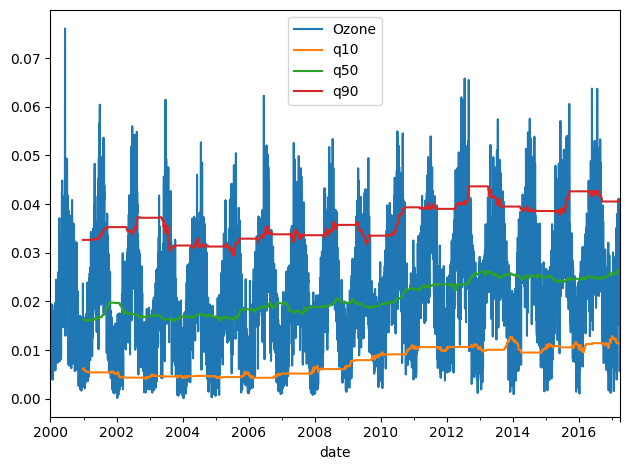

In [39]:
data.plot()
plt.tight_layout()
plt.show()

## Expanding window functions with pandas

- Calculate metrics for periods up to current date
- New times series reflects all historical values up to that point
- Useful for running rate of return, running min/max up to that point in time
- Two options with `pandas`:
    1. `.expanding()` works just like `.rolling()`
    2. short hand methods `.cumsum()`, `.cumprod()`, `.cummim()`, `.cummax()`

In [ ]:
df = pd.DataFrame({'data': range(5)})
df['expanding sum'] = df['data'].expanding().sum()
df['cumsun'] = df['data'].cumsum()
df

,data,expanding sum,cumsun
0,0,0.0,0
1,1,1.0,1
2,2,3.0,3
3,3,6.0,6
4,4,10.0,10


### How to calculate a running return

In [ ]:
sp500 = pd.read_csv('stock_data/sp500.csv', parse_dates=['date'], index_col='date')
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2395 entries, 2007-06-29 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   2395 non-null   float64
dtypes: float64(1)
memory usage: 37.4 KB


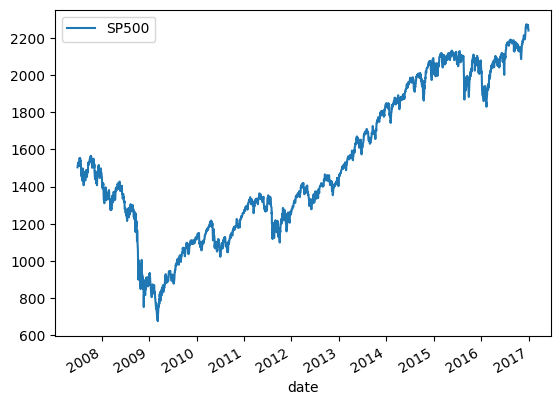

In [ ]:
sp500.plot();

#### Single Period Return

Current `price` over `last price`, minus 1

$$
r_{t} = \frac{P_{t}}{P_{t-1}} - 1
$$

In [ ]:
sp500['single_per_ret'] = sp500['SP500'].div(sp500['SP500'].shift()) - 1
# alternately
sp500['pct_change'] = sp500['SP500'].pct_change()
sp500.head()

,SP500,single_per_ret,pct_change
date,,,
2007-06-29,1503.35,NaN,NaN
2007-07-02,1519.43,0.010696,0.010696
2007-07-03,1524.87,0.003580,0.003580
2007-07-05,1525.40,0.000348,0.000348
2007-07-06,1530.44,0.003304,0.003304


#### Multi-period return

Product of $\left(1 + r_t\right)$ for all periods, minus 1.

$$
R_T = (1 + r_1)(1 + r_2)\dots(1 + r_T) - 1
$$

In [ ]:
sp500['cumulative return'] = sp500['pct_change'].add(1).cumprod().sub(1)
sp500.head()

,SP500,single_per_ret,pct_change,cumulative return
date,,,,
2007-06-29,1503.35,NaN,NaN,NaN
2007-07-02,1519.43,0.010696,0.010696,0.010696
2007-07-03,1524.87,0.003580,0.003580,0.014315
2007-07-05,1525.40,0.000348,0.000348,0.014667
2007-07-06,1530.44,0.003304,0.003304,0.018020


In [ ]:
sp500.tail()

,SP500,single_per_ret,pct_change,cumulative return
date,,,,
2016-12-23,2263.79,0.001252,0.001252,0.505830
2016-12-27,2268.88,0.002248,0.002248,0.509216
2016-12-28,2249.92,-0.008357,-0.008357,0.496604
2016-12-29,2249.26,-0.000293,-0.000293,0.496165
2016-12-30,2238.83,-0.004637,-0.004637,0.489227


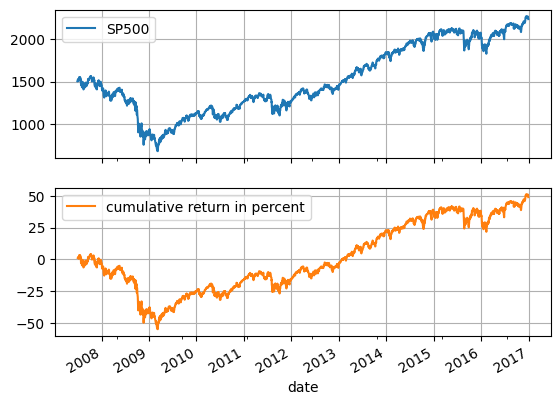

In [ ]:
sp500['cumulative return in percent'] = sp500['cumulative return'].mul(100)
sp500[['SP500', 'cumulative return in percent']].plot(subplots=True, grid=True);

- From the above graph, we can easily see that the SP500 is up 50% since 2007, despite being down 50% in 2009

### Getting the running min & max

In [ ]:
sp500['running min'] = sp500['SP500'].expanding().min()
sp500['running max'] = sp500['SP500'].expanding().max()
sp500

,SP500,single_per_ret,pct_change,cumulative return,cumulative return in percent,running min,running max
date,,,,,,,
2007-06-29,1503.35,NaN,NaN,NaN,NaN,1503.35,1503.35
2007-07-02,1519.43,0.010696,0.010696,0.010696,1.069611,1503.35,1519.43
2007-07-03,1524.87,0.003580,0.003580,0.014315,1.431470,1503.35,1524.87
2007-07-05,1525.40,0.000348,0.000348,0.014667,1.466724,1503.35,1525.40
2007-07-06,1530.44,0.003304,0.003304,0.018020,1.801976,1503.35,1530.44
...,...,...,...,...,...,...,...
2016-12-23,2263.79,0.001252,0.001252,0.505830,50.583031,676.53,2271.72
2016-12-27,2268.88,0.002248,0.002248,0.509216,50.921608,676.53,2271.72
2016-12-28,2249.92,-0.008357,-0.008357,0.496604,49.660425,676.53,2271.72


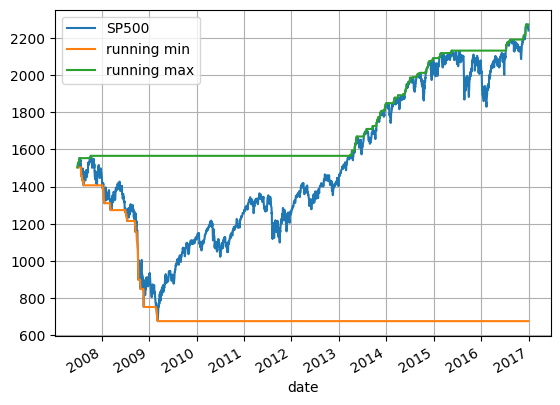

In [ ]:
sp500[['SP500', 'running min', 'running max']].plot(grid=True);

### Rolling annual rate of return

In [ ]:
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

In [ ]:
sp500['Rolling 1yr Return'] = sp500['SP500'].pct_change().rolling('360D').apply(multi_period_return).mul(100)
sp500

,SP500,single_per_ret,pct_change,cumulative return,cumulative return in percent,running min,running max,Rolling 1yr Return
date,,,,,,,,
2007-06-29,1503.35,NaN,NaN,NaN,NaN,1503.35,1503.35,NaN
2007-07-02,1519.43,0.010696,0.010696,0.010696,1.069611,1503.35,1519.43,1.069611
2007-07-03,1524.87,0.003580,0.003580,0.014315,1.431470,1503.35,1524.87,1.431470
2007-07-05,1525.40,0.000348,0.000348,0.014667,1.466724,1503.35,1525.40,1.466724
2007-07-06,1530.44,0.003304,0.003304,0.018020,1.801976,1503.35,1530.44,1.801976
...,...,...,...,...,...,...,...,...
2016-12-23,2263.79,0.001252,0.001252,0.505830,50.583031,676.53,2271.72,8.921938
2016-12-27,2268.88,0.002248,0.002248,0.509216,50.921608,676.53,2271.72,11.005215
2016-12-28,2249.92,-0.008357,-0.008357,0.496604,49.660425,676.53,2271.72,10.077595


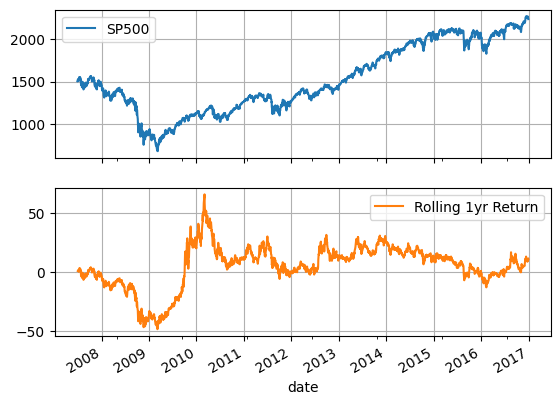

In [ ]:
sp500[['SP500', 'Rolling 1yr Return']].plot(subplots=True, grid=True);

## Case study: S&P 500 price simulation

- Daily stock returns are hard to predict
- Models often assume they are random in nature
- Numpy allows you to generate random numbers
- From random returns to prices: use `.cumprod()`
- Two examples:
  1. Generate random returns (from the bell shaped normal distribution)
  2. Randomly selected actual S&P 500 returns to simulate S&P 500 prices

### Generate random numbers

/var/folders/st/3grdv9_51dqc304ryxkb_ch40000gn/T/ipykernel_70850/3796434118.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(random_returns, fit=norm, kde=False);


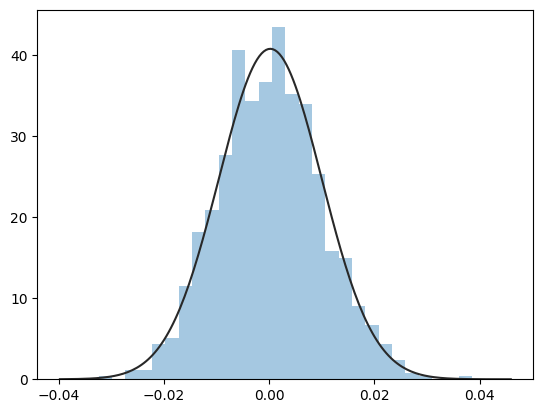

In [ ]:
# from numpy.random import normal, seed
# from scipy.stats import norm


seed(42)
random_returns = normal(loc = 0, scale=0.01, size=1000)

sns.distplot(random_returns, fit=norm, kde=False);

### Create a random price path

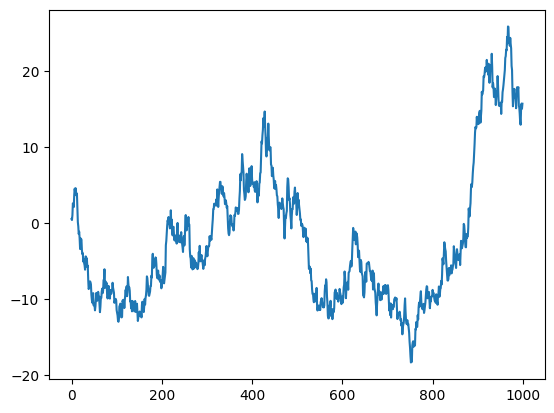

In [ ]:
return_series = pd.Series(random_returns)
random_prices = return_series.add(1).cumprod().sub(1)
random_prices.mul(100).plot();

### S&P 500 prices and returns

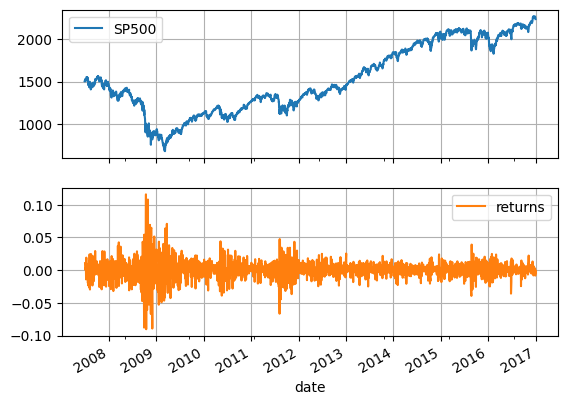

In [ ]:
sp500 = pd.read_csv('stock_data/sp500.csv', parse_dates=['date'], index_col='date')
sp500['returns'] = sp500['SP500'].pct_change()
sp500.plot(subplots=True, grid=True);

### S&P return distribution (compared to normal distribution)

- the shapes don't match very well
- daily stock returns tend to have outliers more often than the normal distribution would suggest

/var/folders/st/3grdv9_51dqc304ryxkb_ch40000gn/T/ipykernel_70850/2567232132.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sp500['returns'].dropna().mul(100), fit=norm);


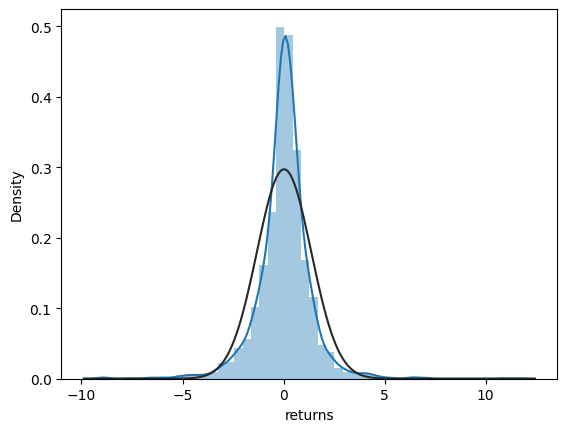

In [ ]:
sns.distplot(sp500['returns'].dropna().mul(100), fit=norm);

### Generate random S&P 500 returns

- randomly selecting from the actual S&P 500 returns

<Axes: xlabel='date'>

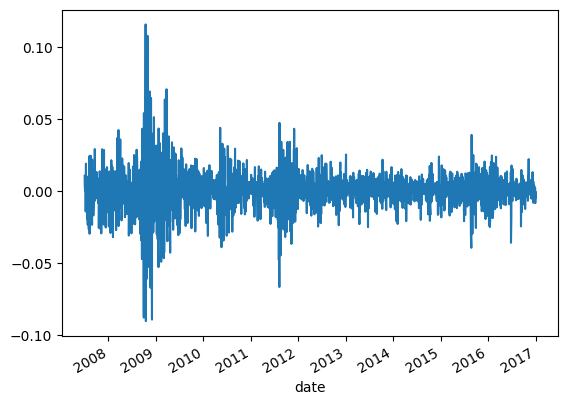

In [ ]:
# from numpy.random import choice

sample = sp500['returns'].dropna()
sample.plot()

In [ ]:
n_obs = sample.count()
random_walk = choice(sample, size=n_obs)
random_walk = pd.Series(random_walk, index=sample.index)
random_walk.head()

date
2007-07-02    0.005007
2007-07-03    0.040729
2007-07-05   -0.000322
2007-07-06   -0.008404
2007-07-09    0.002119
dtype: float64

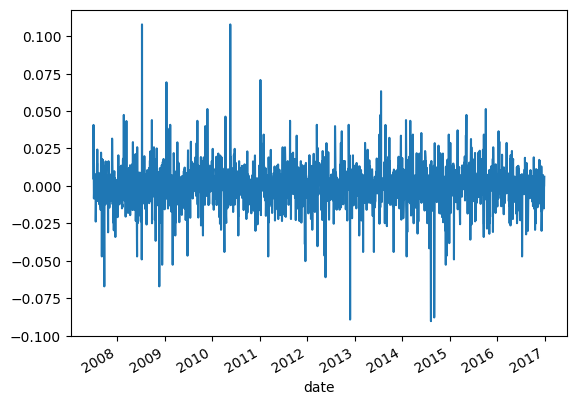

In [ ]:
random_walk.plot();

### Random S&P 500 prices

- Your random walk will start at teh first S&P 500 price

In [ ]:
start = sp500['SP500'].first('D')
start

date
2007-06-29    1503.35
Name: SP500, dtype: float64

In [ ]:
sp500_random = pd.concat([start, random_walk.add(1)])
sp500_random

date
2007-06-29    1503.350000
2007-07-02       1.005007
2007-07-03       1.040729
2007-07-05       0.999678
2007-07-06       0.991596
                 ...     
2016-12-23       1.004895
2016-12-27       0.984949
2016-12-28       0.999290
2016-12-29       1.000017
2016-12-30       1.006095
Length: 2395, dtype: float64

In [ ]:
sp500['SP500_random'] = sp500_random.cumprod()
sp500.head()

,SP500,returns,SP500_random
date,,,
2007-06-29,1503.35,NaN,1503.350000
2007-07-02,1519.43,0.010696,1510.877402
2007-07-03,1524.87,0.003580,1572.413359
2007-07-05,1525.40,0.000348,1571.907656
2007-07-06,1530.44,0.003304,1558.697515


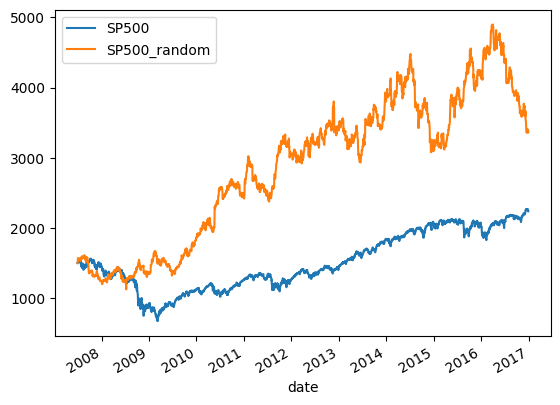

In [ ]:
sp500[['SP500', 'SP500_random']].plot();

## Relationships between time series: correlation

- So far: focus on characteristics between individual variables
- Now: characteristics of relations between variables
- Correlation: measures liner relationships
- Financial markets: important for prediction and risk management
- `pandas` and `seaborn` have tool to compute and visualize these relationships

### Correlation & linear relationships

- **Correlation coefficient**: how similar is the pairwise movement of two variables around their averaages?
- Varies between -1 and 1

$$
r = \frac{\sum_{i=1}^{N}\left(x_i - \bar{x}\right)\left(y_i - \bar{y}\right)}{S_xS_y}
$$

### Five price time series

In [ ]:
data = pd.read_csv('stock_data/asset_classes.csv', parse_dates=['DATE'], index_col='DATE')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2469 entries, 2007-06-29 to 2017-06-26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   2469 non-null   float64
 1   Bonds   2469 non-null   float64
 2   Gold    2469 non-null   float64
 3   Oil     2469 non-null   float64
dtypes: float64(4)
memory usage: 96.4 KB


### Visualize pairwise linear relationships

In [ ]:
daily_returns = data.pct_change()
daily_returns.head()

,SP500,Bonds,Gold,Oil
DATE,,,,
2007-06-29,NaN,NaN,NaN,NaN
2007-07-02,0.010696,0.002014,0.003084,0.009082
2007-07-03,0.003580,-0.002333,0.010377,0.004219
2007-07-05,0.000348,-0.004652,-0.002054,0.005601
2007-07-06,0.003304,-0.002099,-0.012426,0.013786


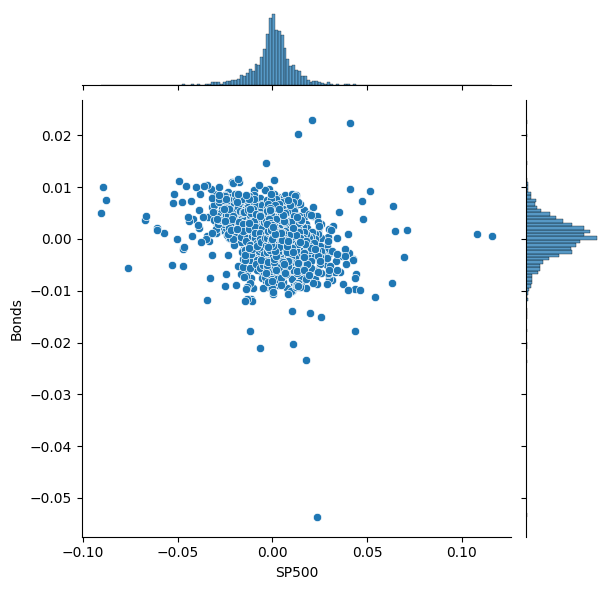

In [ ]:
sns.jointplot(x='SP500', y='Bonds', data=daily_returns);

In [ ]:
correlations = daily_returns.corr()
correlations

,SP500,Bonds,Gold,Oil
SP500,1.000000,-0.314890,-0.006546,0.335353
Bonds,-0.314890,1.000000,0.028882,-0.215279
Gold,-0.006546,0.028882,1.000000,0.104272
Oil,0.335353,-0.215279,0.104272,1.000000


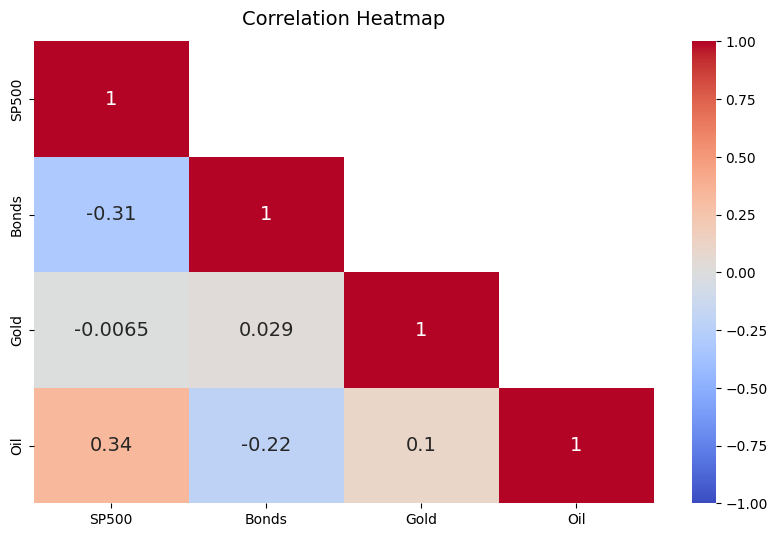

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

mask = np.triu(np.ones_like(correlations, dtype='bool'))
np.fill_diagonal(mask, False)

sns.heatmap(correlations, mask=mask,
            cmap='coolwarm', vmin=-1, vmax=1,
            annot=True, annot_kws={'fontsize': 14})
ax.set_title('Correlation Heatmap', fontdict={'fontsize': 14}, pad=12);